In [1]:
# LOAD LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.python.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils.np_utils import to_categorical

# LOAD THE DATASET
train = pd.read_csv('../dataset/sign_mnist_train.csv')
test  = pd.read_csv('../dataset/sign_mnist_test.csv')

# DATA FOR FURTHER PROCESSING
# take only the 'label' column
y_train = train['label']
# categorize / binarize it
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
# for some reason this inferred 25 classes, which is not what we want
# y_train = to_categorical(y_train, num_classes=24)

# drop the 'label' column
x_train = train.drop(labels='label', axis=1)
# get the underlying ndarray
x_train = x_train.values
# normalize the pixel values
x_train = x_train / 255.0
# reshape them to be 28x28x1 image-like
x_train = x_train.reshape(-1, 28, 28, 1)

# drop the 'label' column
x_test = test.drop(labels='label', axis=1)
# get the underlying ndarray
x_test = x_test.values
# normalize the pixel values
x_test = x_test / 255.0

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [2]:
# first experiment: how many convolution-subsampling pairs is best?
nets = 3
model = [0] * nets

for j in range(3):
    model[j] = Sequential()
    model[j].add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
            input_shape=(28,28,1)))
    model[j].add(MaxPool2D(pool_size=(2,2)))
    if j>0:
        model[j].add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D(pool_size=(2,2)))
    if j>1:
        model[j].add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D(padding='same'))
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(24, activation='softmax'))
    model[j].summary()
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = \
    train_test_split(x_train, y_train, test_size=0.333,
                     random_state=42, shuffle=False)
# TRAIN NETWORKS
history = [0] * nets
names = ["1 Pair","2 Pairs","3 Pairs"]
epochs = 10 # CHANGED THIS FROM 20 to 10 since accuracy is at 100% after 5 epochs already
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs,
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 24)        624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4704)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1204480   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                6168      
Total params: 1,211,272
Trainable params: 1,211,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)            

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-2-29ca2c168407>:32) ]] [Op:__inference_train_function_963]

Function call stack:
train_function


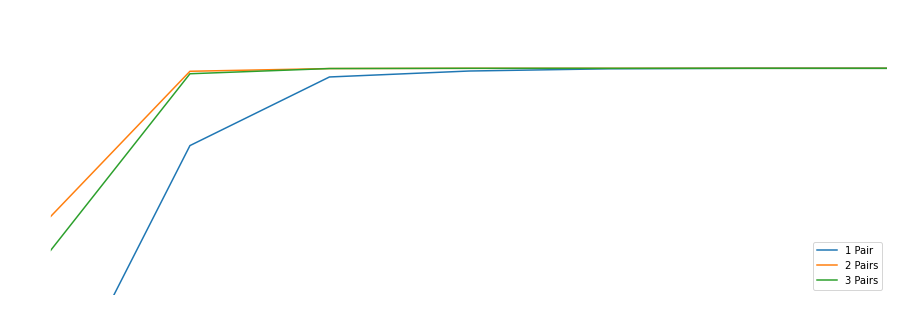

In [3]:
# PLOT ACCURACIES
f = plt.figure(figsize=(15, 5))
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
title_obj = plt.title('validation accuracy') #get the title property handler
plt.setp(title_obj, color='w')
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_xlim([0, 6])
axes.set_ylim([0.9, 1.02])
plt.savefig('experiment_1.png', dpi=f.dpi, format='png', transparent=True)
plt.show()

#RESULT: 2 pairs

In [4]:
# second experiment: how many feature-maps?
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 6
model = [0] *nets
for j in range(6):
    model[j] = Sequential()
    model[j].add(Conv2D(j*8+8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(j*16+16,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(24, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = \
    train_test_split(x_train, y_train, test_size = 0.333, random_state=42, shuffle=False)
# TRAIN NETWORKS
history = [0] * nets
names = ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs,
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 8 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 16 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 24 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 32 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 48 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 64 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000


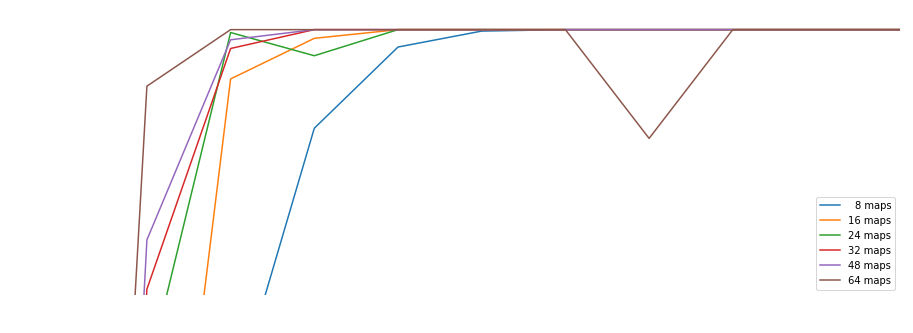

In [5]:
# PLOT ACCURACIES
f = plt.figure(figsize=(15, 5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'])
title_obj = plt.title('validation accuracy') #get the title property handler
plt.setp(title_obj, color='w')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
leg = axes.get_legend()
renderer = f.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for test in leg.get_texts():
    test.set_horizontalalignment('right')
    test.set_position((shift, 0))
axes.set_xlim([0, 10])
axes.set_ylim([0.9800, 1.0005])
plt.savefig('experiment_2.png', dpi=f.dpi, format='png', transparent=True)
plt.show()

# RESULT: 32 in first, 64 in second conv layer

In [6]:
# third experiment: how many units in the dense layer?

# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())
    if j>0:
        model[j].add(Dense(2**(j+4), activation='relu'))
    model[j].add(Dense(24, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = \
    train_test_split(x_train, y_train, test_size = 0.333, random_state=42, shuffle=False)
# TRAIN NETWORKS
history = [0] * nets
names = ["0 units","32 units","64 units","128 units","256 units",
         "512 units","1024 units","2048 units"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs,
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 0 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 32 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 64 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 128 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 256 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 512 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 1024 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 2048 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000


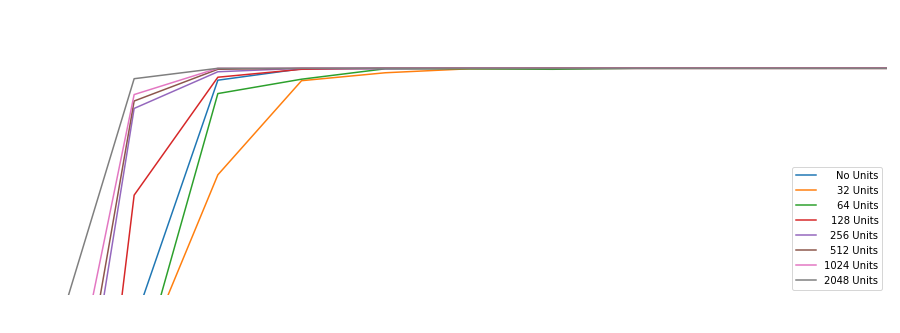

In [7]:
names = ["No Units","32 Units","64 Units","128 Units","256 Units",
         "512 Units","1024 Units","2048 Units"]
# PLOT ACCURACIES
f = plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'])
title_obj = plt.title('validation accuracy') #get the title property handler
plt.setp(title_obj, color='w')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
leg = axes.get_legend()
renderer = f.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for test in leg.get_texts():
    test.set_horizontalalignment('right')
    test.set_position((shift, 0))
axes.set_ylim([0.95, 1.01])
axes.set_xlim([0, 10])
# axes.set_facecolor((.3,.3,.3))
plt.savefig('experiment_3.png', dpi=f.dpi, format='png', transparent=True)
plt.show()

# RESULT: 128 Neurons in the dense layer

In [8]:
# fourth experiment: how much dropout should we use

# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] * nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Flatten())
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(j*0.1))
    model[j].add(Dense(24, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = \
    train_test_split(x_train, y_train, test_size = 0.333, random_state=42, shuffle=False)
# TRAIN NETWORKS
history = [0] * nets
names = ["No Dropout","0.1 Dropout", "0.2 Dropout", "0.3 Dropout",
         "0.4 Dropout", "0.5 Dropout","0.6 Dropout","0.7 Dropout"]
epochs = 30
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs,
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN No Dropout: Epochs=30, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 0.1 Dropout: Epochs=30, Train accuracy=0.99995, Validation accuracy=1.00000
CNN 0.2 Dropout: Epochs=30, Train accuracy=0.99945, Validation accuracy=1.00000
CNN 0.3 Dropout: Epochs=30, Train accuracy=0.99694, Validation accuracy=1.00000
CNN 0.4 Dropout: Epochs=30, Train accuracy=0.99290, Validation accuracy=1.00000
CNN 0.5 Dropout: Epochs=30, Train accuracy=0.98296, Validation accuracy=1.00000
CNN 0.6 Dropout: Epochs=30, Train accuracy=0.93130, Validation accuracy=1.00000
CNN 0.7 Dropout: Epochs=30, Train accuracy=0.81422, Validation accuracy=0.99431


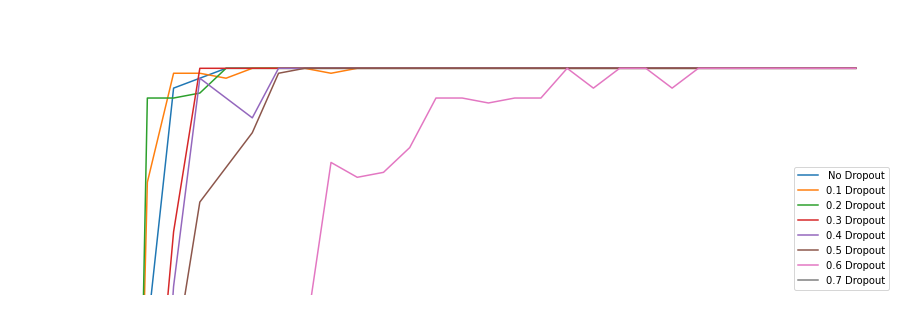

In [9]:
# PLOT ACCURACIES
plt.figure(figsize=(15, 5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'])
title_obj = plt.title('validation accuracy') #get the title property handler
plt.setp(title_obj, color='w')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
leg = axes.get_legend()
renderer = f.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for test in leg.get_texts():
    test.set_horizontalalignment('right')
    test.set_position((shift, 0))
axes.set_ylim([0.995, 1.001])
plt.savefig('experiment_4.png', dpi=f.dpi, format='png', transparent=True)
plt.show()

# RESULT 0.3 DROPOUT
